In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
import pandas as pd
from pyspark.sql.types import BooleanType, StringType, FloatType, MapType, IntegerType, StructType, StructField, ArrayType, DoubleType, TimestampType
from pyspark.sql.functions import col, when, max, min, lit, explode, split, regexp_replace, lower, concat, mean
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import min, max
#from unidecode import unidecode
import string
import nltk
import datetime
nltk.download('stopwords')
import matplotlib as mp
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
news = spark.read.format('csv').option("escape","\"").option('header',True).load("s3://msbx5420-2020/team_grays_peak/news.csv/")

In [4]:
def remove_non_ascii(text):
    if not text:
        return None
        return unidecode(str(text)).replace("*", ".").replace("\n", '.')

udf_remove_non_ascii = udf(remove_non_ascii, StringType())

def sent_tokenize(text):
    if not text:
        return None
    try:
        sent_text = nltk.sent_tokenize(text)
    except:
        import nltk
        nltk.download('punkt')
        sent_text = nltk.sent_tokenize(text)

    return sent_text

udf_sent_tokenize = udf(sent_tokenize, ArrayType(StringType()))

def remove_punctuations(text):
    if not text:
        return None
    table = str.maketrans({key: ' ' for key in string.punctuation if key!='+' and key!='-' and key!='#'})
    text = text.translate(table)
    text = ' '.join(text.split())
    return text

udf_remove_punctuations = udf(remove_punctuations, StringType())

def merge_hyphen(text):
    if not text:
        return None
    return text.replace("-", "")

udf_merge_hyphen = udf(merge_hyphen, StringType())

In [5]:
from nltk.corpus import stopwords

def remove_stopwords_1(text):
    if not text:
        return None
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    query = text
    stop = [' i ', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
            "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 
            'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 
            'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 
            'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 
            'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 
            'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 
            'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 
            'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 
            'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 
            'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 
            'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 
            'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 
            'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
            'won', "won't", 'wouldn', "wouldn't", 'says', ' s', 'said', 'new', 'confirmed', 'say']
    querywords = query.split()
    resultwords = [word for word in querywords if word.lower() not in stop]
    result = ' '.join(resultwords)
    return result
    
udf_rem_stopwords_1 = udf(remove_stopwords_1, StringType())

In [6]:
news_1 = news.withColumn("description_rem_stopwords", udf_rem_stopwords_1(news['description'])).distinct()
news_2 = news_1.withColumn("news_rem_punct", udf_remove_punctuations(news_1['description_rem_stopwords']))
news_2.count()

3566

In [13]:
rdd1 = news_2.select('news_rem_punct').rdd.map(lambda row : row[0]).collect()

In [15]:
text_df=pd.DataFrame(rdd1)
text=str(text_df)

<Figure size 1008x720 with 0 Axes>

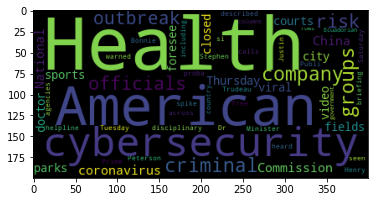

<Figure size 1008x720 with 0 Axes>

In [31]:
stopwords_1 = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stopwords_1).generate(text)
plt.imshow(wordcloud)
plt.figure(figsize = (14,10), facecolor = "Blue") 